<a href="https://colab.research.google.com/github/ZahraMousakhani/CS-SBU-NeuralNetwork_MSc2021-projects/blob/main/ZahraMousakhani-99422187/project3/VariationalAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zahramousakhani","key":"755da9f324f8575f4914cdb3228a0941"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

fruits.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

fruits.zip  kaggle.json  sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('fruits.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
import os
train_root = '/content/files/fruits-360/Training'
val_root = '/content/files/fruits-360/Test'
os.makedirs('/content/files/fruits-360/results', exist_ok=True)
os.makedirs('/content/files/fruits-360/results/samples', exist_ok=True)

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from skimage import io, transform
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [ ]:
batch_size = 64
epochs = 5
no_cuda = False
seed = 1
log_interval = 50

cuda =  torch.cuda.is_available()
print (cuda)
print (torch.cuda.is_available)

torch.manual_seed(seed)

False
<function is_available at 0x7f10b14b1830>


In [ ]:
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [ ]:
train_loader_fruit= torch.utils.data.DataLoader(
    datasets.ImageFolder(train_root, transform=transforms.ToTensor()),
    batch_size = batch_size, shuffle=True, **kwargs)

val_loader_fruit = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_root, transform=transforms.ToTensor()),
    batch_size = batch_size, shuffle=True, **kwargs)

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 100, 100)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 25 * 25 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

In [ ]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    def forward(self, recon_x, x, mu, logvar):
        MSE = self.mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2)-logvar.exp())
        return MSE + KLD
loss_mse = Loss()

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print (model)

VAE(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10000, out_features=2048, bias=True)
  (fc_bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=2048, out_features=2048, bias=True)
  (fc22): Linear(in_features=2048, out_features=2048, bias=T

In [ ]:
print(torch.cuda.is_available())
val_losses = []
train_losses = []

False


In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader_fruit):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_fruit.dataset),
                       100. * batch_idx / len(train_loader_fruit),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader_fruit.dataset)))
    train_losses.append(train_loss / len(train_loader_fruit.dataset))

In [ ]:

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader_fruit):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_mse(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 3, 100, 100)[:n]])
                save_image(comparison.cpu(),
                           '/content/files/fruits-360/results' + str(epoch) + '.png', nrow=n)

    test_loss /= len(val_loader_fruit.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [ ]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2048).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 3, 100, 100),
                   '/content/files/fruits-360/results/samples' + str(epoch) + '.png')

Train Epoch: 1 [0/67692 (0%)]	Loss: 68839.140625
Train Epoch: 1 [3200/67692 (5%)]	Loss: 3960.718750
Train Epoch: 1 [6400/67692 (9%)]	Loss: 2150.585693
Train Epoch: 1 [9600/67692 (14%)]	Loss: 1329.083984
Train Epoch: 1 [12800/67692 (19%)]	Loss: 1238.383667
Train Epoch: 1 [16000/67692 (24%)]	Loss: 1800.640503
Train Epoch: 1 [19200/67692 (28%)]	Loss: 922.942261
Train Epoch: 1 [22400/67692 (33%)]	Loss: 899.479126
Train Epoch: 1 [25600/67692 (38%)]	Loss: 867.111877
Train Epoch: 1 [28800/67692 (43%)]	Loss: 756.213257
Train Epoch: 1 [32000/67692 (47%)]	Loss: 753.011108
Train Epoch: 1 [35200/67692 (52%)]	Loss: 704.381531
Train Epoch: 1 [38400/67692 (57%)]	Loss: 670.440186
Train Epoch: 1 [41600/67692 (61%)]	Loss: 763.490234
Train Epoch: 1 [44800/67692 (66%)]	Loss: 612.373779
Train Epoch: 1 [48000/67692 (71%)]	Loss: 699.943176
Train Epoch: 1 [51200/67692 (76%)]	Loss: 589.704895
Train Epoch: 1 [54400/67692 (80%)]	Loss: 637.673035
Train Epoch: 1 [57600/67692 (85%)]	Loss: 620.188904
Train Epoch: 1 

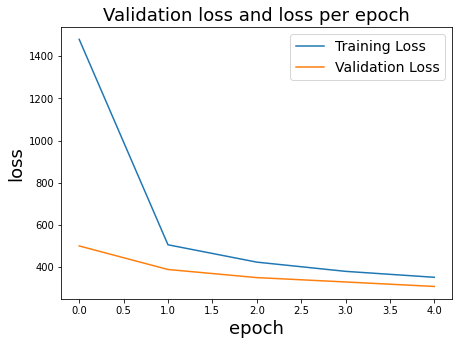

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.title("Validation loss and loss per epoch",fontsize=18)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.show()

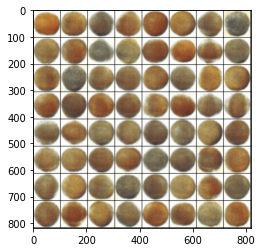

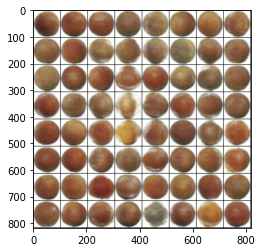

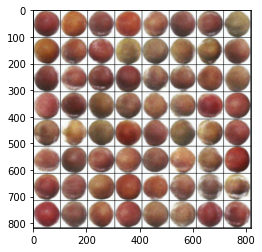

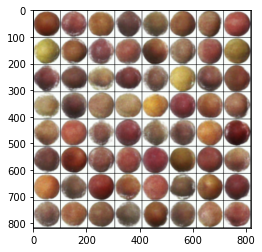

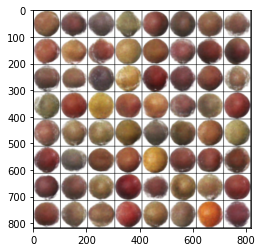

In [ ]:
from skimage.io import imread
from pylab import *
for x in range(1, 6):
  filename = '/content/files/fruits-360/results/samples' + str(x) + '.png'
  I = imread(filename)
  imshow(I)
  show()